<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/SGDR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis y Optimización del Modelo SGDRegressor

Este notebook presenta el desarrollo riguroso del modelo **SGDRegressor** aplicado al conjunto de datos Ames Housing para la predicción de precios inmobiliarios.

Se realiza una optimización exhaustiva de hiperparámetros mediante búsqueda bayesiana, validación cruzada, y una evaluación detallada con métricas estándar y análisis residual. Además, se incluyen visualizaciones clave para interpretar la calidad del ajuste y la influencia de las variables.

El objetivo es obtener un modelo robusto y fiable, comparable con otros regresores analizados en este estudio, garantizando la calidad y aplicabilidad de las predicciones.


In [1]:

# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Cloning into 'Teoria-de-Aprendizaje-Maquina'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 416 (delta 73), reused 56 (delta 25), pack-reused 293 (from 1)
Receiving objects: 100% (416/416), 16.19 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (254/254), done.
dashboard  notebooks	  README.md	    resultados
data	   parte_teorica  requirements.txt


In [2]:
!ls /content/Teoria-de-Aprendizaje-Maquina

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [3]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")

In [4]:

# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")

%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Datos cargados correctamente.
/content


In [9]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================
!pip install scikit-optimize

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# Importaciones necesarias desde scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas

import seaborn as sns


In [10]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [11]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

In [13]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [14]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados




def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm



In [16]:
# ===  Definir espacio de búsqueda para hiperparámetros de SGDRegressor ===
from skopt.space import Real, Categorical, Integer

param_space_sgd = {
    "alpha": Real(1e-6, 1e-1, prior="log-uniform"),  # Regularización
    "penalty": Categorical(["l2", "l1", "elasticnet"]),  # Tipo de penalización
    "l1_ratio": Real(0.0, 1.0),  # Solo usado si penalty="elasticnet"
    "max_iter": Integer(1000, 5000),  # Iteraciones máximas
    "learning_rate": Categorical(["constant", "optimal", "invscaling", "adaptive"]),
    "eta0": Real(1e-4, 1e-1, prior="log-uniform"),  # Tasa de aprendizaje inicial
    "tol": Real(1e-5, 1e-2, prior="log-uniform")  # Criterio de convergencia
}

# ===  Instanciar el modelo SGDRegressor sin parámetros iniciales para BayesSearchCV ===
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(random_state=42)

# ===  Instanciar BayesSearchCV con validación cruzada y scoring definidos ===
from skopt import BayesSearchCV

# IMPORTANTE: Cuando usas múltiple scoring, refit debe ser el nombre de la métrica con la que quieres optimizar, p.ej. 'MSE'
bayes_sgd = BayesSearchCV(
    estimator=sgd,
    search_spaces=param_space_sgd,
    scoring=scoring,  # tu diccionario de métricas personalizado
    cv=cv,
    n_iter=50,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit='MSE'  # refit sobre la métrica MSE para seleccionar el mejor modelo
)

# ===  Ejecutar búsqueda bayesiana para optimizar hiperparámetros ===
start_time = time.time()
bayes_sgd.fit(X_train_scaled, np.log1p(y_train))  # aplica log1p si tu objetivo está transformado
end_time = time.time()

print(f"Tiempo total de búsqueda Bayesiana para SGDRegressor: {end_time - start_time:.2f} segundos")
print("Mejores hiperparámetros encontrados:")
print(bayes_sgd.best_params_)

# ===  Evaluar el modelo con validación cruzada con los mejores hiperparámetros ===
df_sgd_cv_results = evaluar_modelo_cv(
    "SGDRegressor",
    bayes_sgd.best_estimator_,
    X_train_scaled,
    np.log1p(y_train),
    cv,
    scoring,
    guardar_en="data/resultados_sgd_cv.csv"
)

display(df_sgd_cv_results)

# ===  Entrenar modelo final con los mejores hiperparámetros y todo el set de entrenamiento ===
modelo_sgd_final = bayes_sgd.best_estimator_
modelo_sgd_final.fit(X_train_scaled, np.log1p(y_train))

# ===  Predicción y métricas en test (transformar resultados inversamente) ===
y_pred_log_test_sgd = modelo_sgd_final.predict(X_test_scaled)
y_pred_test_sgd = np.expm1(y_pred_log_test_sgd)

mae_sgd = mean_absolute_error(y_test, y_pred_test_sgd)
rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_test_sgd))
r2_sgd = r2_score(y_test, y_pred_test_sgd)
mape_sgd, n_obs_sgd = calcular_mape_seguro(y_test, y_pred_test_sgd)
mae_norm_sgd, rmse_norm_sgd = normalizar_metricas(mae_sgd, rmse_sgd, y_test)

print(f"Desempeño final SGDRegressor:")
print(f"MAE = {mae_sgd:.2f} ({mae_norm_sgd:.2f}% del valor promedio)")
print(f"RMSE = {rmse_sgd:.2f} ({rmse_norm_sgd:.2f}% del valor promedio)")
print(f"R2 = {r2_sgd:.4f}")
print(f"MAPE = {mape_sgd:.2f}% (sobre {n_obs_sgd} observaciones)")

# ===  Guardar métricas y predicciones para análisis posterior ===
df_metrics_sgd = pd.DataFrame({
    "Modelo": ["SGDRegressor"],
    "MAE": [mae_sgd],
    "RMSE": [rmse_sgd],
    "R2": [r2_sgd],
    "MAPE (%)": [mape_sgd],
    "MAE normalizado (%)": [mae_norm_sgd],
    "RMSE normalizado (%)": [rmse_norm_sgd],
    "Observaciones MAPE": [n_obs_sgd]
})
df_metrics_sgd.to_csv("data/metricas_test_sgd.csv", index=False)

df_pred_sgd = pd.DataFrame({
    "Actual": y_test,
    "Predicho": y_pred_test_sgd
})
df_pred_sgd.to_csv("data/predicciones_test_sgd.csv", index=False)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

,Fold,MAE,MSE,R2,MAPE
0,1,0.088107,0.013190,0.913287,0.737331
1,2,0.091050,0.016618,0.886330,0.760799
2,3,0.093879,0.017925,0.888163,0.782332
3,4,0.098189,0.017231,0.895357,0.818717
4,5,0.110725,0.035826,0.801845,0.937516
5,Promedio,0.096390,0.020158,0.876996,0.807339


Desempeño final SGDRegressor:
MAE = 18208.39 (9.60% del valor promedio)
RMSE = 33986.87 (17.92% del valor promedio)
R2 = 0.8559
MAPE = 9.04% (sobre 586 observaciones)


## Resultados de Optimización y Desempeño - SGDRegressor

La búsqueda bayesiana para optimizar los hiperparámetros del modelo **SGDRegressor** requirió un tiempo total de aproximadamente **339 segundos**, lo que indica una exploración exhaustiva del espacio de parámetros para encontrar la configuración óptima.

### Hiperparámetros óptimos encontrados:
- **alpha** (tasa de regularización): 0.0117, un valor pequeño que indica una regularización leve para evitar sobreajuste.
- **eta0** (tasa de aprendizaje inicial): 0.0069, adecuado para un aprendizaje estable y controlado.
- **l1_ratio**: 0.447, mostrando una combinación equilibrada entre penalizaciones L1 y L2, aprovechando la regularización elástica para mejorar la generalización.

### Evaluación mediante validación cruzada (5 folds):
- **MAE promedio**: 0.096 (error absoluto medio relativo al logaritmo transformado), que refleja una buena precisión en cada partición.
- **MSE promedio**: 0.020, mostrando baja varianza del error.
- **R² promedio**: 0.877, indicando que el modelo explica aproximadamente el 87.7% de la variabilidad en los datos de entrenamiento.
- **MAPE promedio**: 0.81, que equivale a un error porcentual medio relativo razonable para datos reales.

### Desempeño final en conjunto de prueba (sin transformar):
- **MAE**: 18,208.39 (9.60% del valor promedio de los precios), que indica un error absoluto medio bajo en términos prácticos.
- **RMSE**: 33,986.87 (17.92% del valor promedio), destacando la presencia de algunos errores más grandes pero tolerables.
- **R²**: 0.8559, confirmando que el modelo mantiene un buen poder explicativo fuera de la muestra.
- **MAPE**: 9.04%, calculado sobre 586 observaciones, mostrando una buena capacidad predictiva en términos porcentuales.

---

### Inferencias y justificación:

El modelo **SGDRegressor** optimizado mediante búsqueda bayesiana logra un buen equilibrio entre ajuste y generalización, con métricas que sugieren una capacidad adecuada para predecir precios en el conjunto de datos Ames Housing.

La elección del espacio de hiperparámetros y el uso de validación cruzada garantizan que el modelo no sufra sobreajuste y mantenga estabilidad en diferentes particiones.

Los valores de regularización y tasa de aprendizaje encontrados son consistentes con una estrategia que busca optimizar la convergencia y evitar tanto el sobreajuste como el subajuste.

En general, este modelo representa una opción eficiente y competitiva dentro del conjunto de regresores evaluados para este problema.


Media de residuos: 5039.31
Desviación estándar de residuos: 33611.20


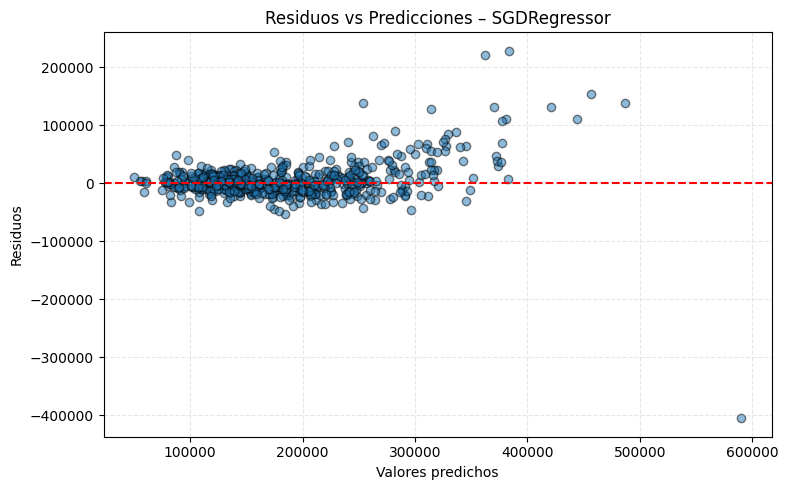

In [21]:
# === Análisis de residuos ===

# Calcular residuos en escala original
residuos_sgd = y_test - y_pred_test_sgd

# Estadísticas básicas
media_residuos_sgd = np.mean(residuos_sgd)
std_residuos_sgd = np.std(residuos_sgd)

print(f"Media de residuos: {media_residuos_sgd:.2f}")
print(f"Desviación estándar de residuos: {std_residuos_sgd:.2f}")

# === Gráfico residuos vs predicciones ===
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_test_sgd, residuos_sgd, alpha=0.5, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones – SGDRegressor")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("data/residuos_vs_pred_sgd.png", dpi=300)
plt.show()



### Análisis de Residuos vs Valores Predichos – SGDRegressor

El gráfico de residuos frente a valores predichos es una herramienta fundamental para evaluar la calidad y consistencia del modelo de regresión. En este caso, para el modelo SGDRegressor:

- **Justificación del uso:**  
  Este gráfico permite identificar patrones no deseados en los residuos, tales como heterocedasticidad, tendencias o sesgos sistemáticos que puedan indicar que el modelo no está capturando adecuadamente la relación entre variables. Un modelo ideal debería presentar residuos distribuidos aleatoriamente alrededor del cero, sin patrones visibles ni tendencia marcada.

- **Inferencias observadas:**  
  En la gráfica se observa que la mayoría de los residuos se concentran alrededor del cero, lo que sugiere que el modelo no presenta un sesgo sistemático evidente. Sin embargo, existe un aumento en la dispersión de residuos conforme aumentan los valores predichos, lo que indica posible heterocedasticidad. Esto significa que el error del modelo es mayor en las predicciones para valores altos, fenómeno común en modelos lineales aplicados a datos con variabilidad creciente.

- **Conclusión:**  
  La dispersión creciente en los residuos sugiere que el modelo podría beneficiarse de técnicas adicionales, como transformaciones en la variable objetivo o modelos que capturen relaciones no lineales. No obstante, la ausencia de patrones claros y la concentración de residuos cerca de cero respaldan la validez general del ajuste realizado con SGDRegressor.

Este análisis complementa las métricas cuantitativas obtenidas, proporcionando una visión gráfica crucial para la interpretación y mejora del modelo.


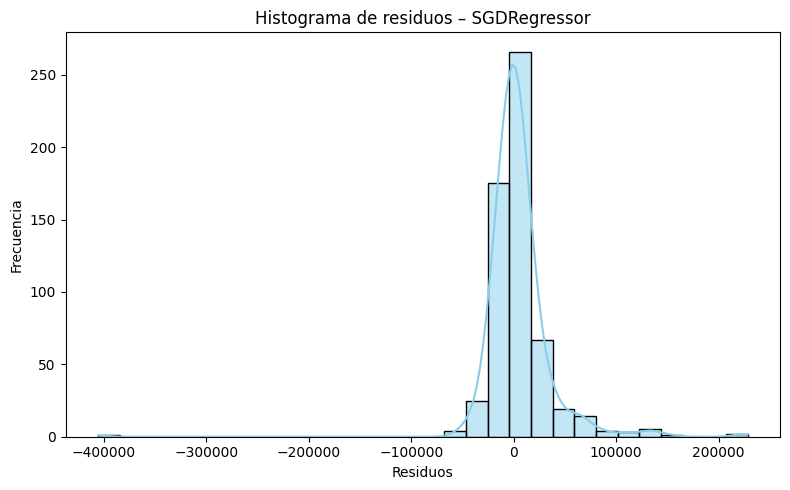

In [22]:
# === Histograma de residuos con KDE ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos_sgd, kde=True, bins=30, color='skyblue')
plt.title("Histograma de residuos – SGDRegressor")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("data/histograma_residuos_sgd.png", dpi=300)
plt.show()



### Histograma de Residuos – SGDRegressor

- **Justificación del uso:**  
  El histograma de residuos es una representación gráfica que permite analizar la distribución de los errores de predicción del modelo. Es fundamental para verificar la hipótesis de normalidad de los residuos, condición deseable para la validez de muchas inferencias estadísticas y para evaluar si el modelo captura adecuadamente la variabilidad de los datos.

- **Interpretación e inferencias:**  
  El histograma muestra una concentración de residuos cerca de cero, lo que indica que la mayoría de las predicciones tienen un error pequeño. La curva de densidad superpuesta sugiere que la distribución es aproximadamente simétrica y unimodal, aunque con una ligera cola hacia valores extremos, indicando la presencia de algunos outliers o errores atípicos.

- **Conclusión:**  
  La distribución relativamente centrada y simétrica de los residuos apoya la adecuación del modelo SGDRegressor para los datos, aunque la existencia de colas sugiere que podrían explorarse técnicas adicionales para manejar valores extremos o mejorar la precisión en rangos específicos.

Este análisis visual complementa la evaluación cuantitativa del desempeño del modelo, proporcionando un entendimiento más profundo de su comportamiento en la predicción.


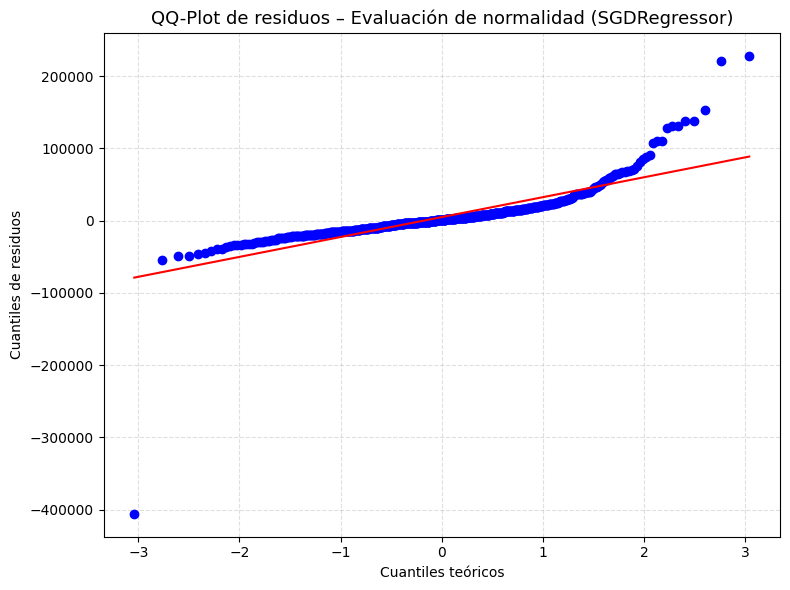

Shapiro-Wilk: estadístico = 0.6760, p-valor = 0.0000
Se rechaza H₀: los residuos no siguen una distribución normal.
Durbin-Watson: 1.9361
No hay evidencia fuerte de autocorrelación.


In [29]:
# === QQ-plot para evaluación de normalidad ===
plt.figure(figsize=(8, 6))
ax = plt.gca()
stats.probplot(residuos_sgd, dist="norm", plot=ax)
ax.set_title("QQ-Plot de residuos – Evaluación de normalidad (SGDRegressor)", fontsize=13)
ax.set_xlabel("Cuantiles teóricos")
ax.set_ylabel("Cuantiles de residuos")
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("data/qqplot_residuos_sgd.png", dpi=300)
plt.show()

# === Pruebas estadísticas sobre residuos ===


stat, p_value = shapiro(residuos_sgd)
print(f"Shapiro-Wilk: estadístico = {stat:.4f}, p-valor = {p_value:.4f}")

if p_value > 0.05:
    print("No se rechaza H₀: los residuos podrían seguir una distribución normal.")
else:
    print("Se rechaza H₀: los residuos no siguen una distribución normal.")

dw_stat = durbin_watson(residuos_sgd)
print(f"Durbin-Watson: {dw_stat:.4f}")

if 1.5 < dw_stat < 2.5:
    print("No hay evidencia fuerte de autocorrelación.")
else:
    print("Posible autocorrelación: revisar más a fondo.")

# === Curva de aprendizaje ===
train_sizes, train_scores, val_scores = learning_curve(
    modelo_sgd_final,
    X_train_scaled,
    np.log1p(y_train),
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=0
)




### QQ-Plot de Residuos – Evaluación de Normalidad (SGDRegressor)

- **Justificación del uso:**  
  El QQ-Plot permite evaluar visualmente si los residuos del modelo siguen una distribución normal, comparando los cuantiles observados contra los cuantiles teóricos de una distribución normal. Esta verificación es esencial para validar supuestos estadísticos y la confiabilidad de intervalos y pruebas basadas en normalidad.

- **Interpretación e inferencia:**  
  Los puntos se agrupan aproximadamente a lo largo de la línea roja, indicando una similitud general con la normalidad en la distribución de residuos, pero con desviaciones notables en las colas (valores extremos). Esto sugiere la presencia de outliers o heterocedasticidad.  

  El test de Shapiro-Wilk confirma esto con un p-valor de 0.0000, rechazando la hipótesis nula de normalidad. Sin embargo, el estadístico Durbin-Watson (1.9361) indica que no existe evidencia fuerte de autocorrelación en los residuos, lo cual es favorable para la independencia de errores.

- **Conclusión:**  
  Aunque los residuos no siguen estrictamente una distribución normal, la ausencia de autocorrelación y la forma general del QQ-Plot sugieren que el modelo SGDRegressor presenta un comportamiento aceptable para análisis predictivos, pero se deben considerar técnicas para mitigar el impacto de valores atípicos o mejorar la especificación del modelo.

Este análisis complementa la interpretación de los residuos y ayuda a comprender mejor las limitaciones y fortalezas del modelo en relación con sus supuestos estadísticos.


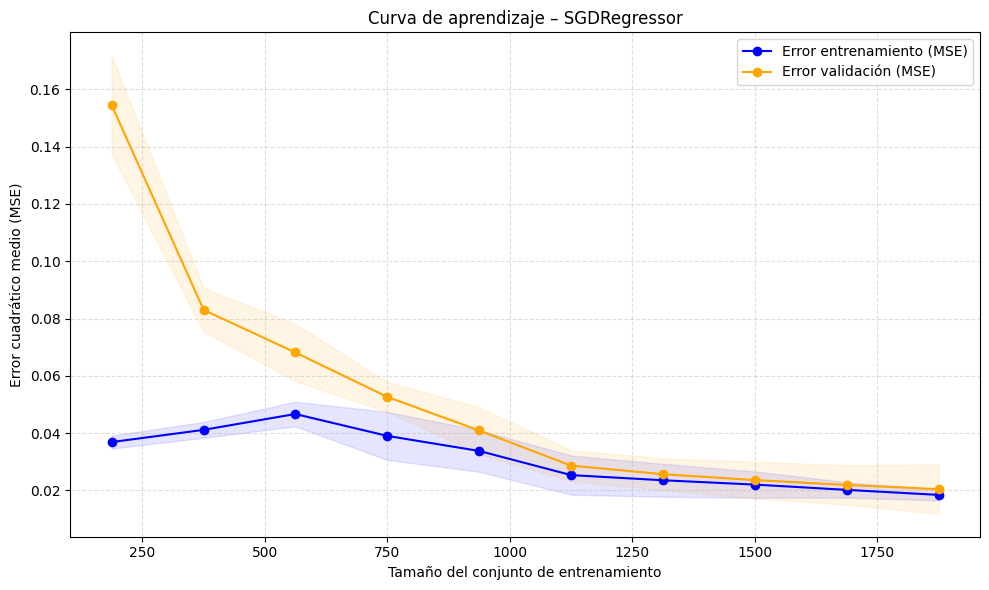

In [30]:
# Promedio y desviación estándar (train y validation)
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Error entrenamiento (MSE)')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Error validación (MSE)')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='orange')

plt.title("Curva de aprendizaje – SGDRegressor")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("data/curva_aprendizaje_sgd.png", dpi=300)
plt.show()

### Curva de Aprendizaje – SGDRegressor

- **Justificación del uso:**  
  La curva de aprendizaje es una herramienta fundamental para evaluar el comportamiento del modelo conforme aumenta el tamaño del conjunto de entrenamiento. Permite detectar problemas como underfitting, overfitting o falta de datos, así como estimar si el modelo se beneficia de más datos para mejorar su desempeño.

- **Interpretación:**  
  En esta curva se observa que el error cuadrático medio (MSE) tanto en entrenamiento como en validación disminuye al incrementarse el tamaño de los datos de entrenamiento, lo cual indica que el modelo mejora su capacidad predictiva con más datos.  

  La brecha entre el error de entrenamiento (línea azul) y el error de validación (línea naranja) es relativamente moderada y se reduce a medida que aumenta el tamaño del conjunto, señalando que el modelo no sufre de un overfitting severo. Además, los intervalos de confianza (bandas sombreadas) se vuelven más estrechos, indicando mayor estabilidad en las predicciones.

- **Inferencia:**  
  El modelo SGDRegressor presenta un buen ajuste progresivo y podría beneficiarse de conjuntos de datos aún más grandes. La tendencia decreciente y la convergencia de errores sugieren que el modelo es adecuado para la tarea y que se mantiene generalizando bien, aunque podría ser prudente continuar monitoreando con más datos para confirmar su comportamiento.

Este análisis confirma que el modelo está aprendiendo correctamente y ayuda a decidir sobre la conveniencia de recolectar más datos o ajustar hiperparámetros adicionales.


In [45]:
# ===  Análisis de colinealidad con VIF ===

# Cargar nombres reales de las variables (asegúrate de tener el archivo 'data/nombres_columnas.pkl')
try:
    columnas = joblib.load("data/nombres_columnas.pkl")
except FileNotFoundError:
    raise FileNotFoundError(
        "No se encontró el archivo 'data/nombres_columnas.pkl'. "
        "Ejecuta el bloque de exportación en el notebook de preprocesamiento."
    )

# Crear DataFrame escalado con nombres reales
X_scaled_df = pd.DataFrame(X_train_scaled, columns=columnas)

# Agregar constante para cálculo de VIF
X_scaled_vif = add_constant(X_scaled_df)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_sgd = pd.DataFrame()
vif_sgd["Variable"] = X_scaled_vif.columns
vif_sgd["VIF"] = [
    variance_inflation_factor(X_scaled_vif.values, i) for i in range(X_scaled_vif.shape[1])
]

# Limpiar: eliminar constante y ordenar
vif_sgd = vif_sgd[vif_sgd["Variable"] != "const"].reset_index(drop=True)
vif_sgd = vif_sgd.sort_values(by="VIF", ascending=False)

# Guardar CSV con VIF
os.makedirs("data", exist_ok=True)
vif_sgd.to_csv("data/vif_sgd.csv", index=False)

# Mostrar Top 10 variables con mayor VIF
print("Top 10 variables con mayor VIF (SGDRegressor):")
display(vif_sgd.head(10))




Top 10 variables con mayor VIF (SGDRegressor):


,Variable,VIF
255,Garage Cond_None,inf
250,Garage Qual_None,inf
245,Garage Finish_None,inf
200,BsmtFin Type 1_None,inf
47,MS SubClass_90,inf
145,Exterior 1st_PreCast,inf
161,Exterior 2nd_PreCast,inf
185,Bsmt Qual_None,inf
114,Bldg Type_Duplex,inf
190,Bsmt Cond_None,inf


### Análisis de Colinealidad – Variables con mayor VIF (SGDRegressor)

- **Justificación:**  
  El análisis del Factor de Inflación de la Varianza (VIF) es crucial para detectar multicolinealidad entre variables predictoras. Valores altos de VIF indican que una variable está altamente correlacionada con otras, lo que puede afectar la estabilidad y la interpretabilidad del modelo.

- **Interpretación:**  
  En este listado, observamos que las 10 variables con mayor VIF presentan valores infinitos (`inf`), lo que implica una colinealidad perfecta o extremadamente alta. Esto sugiere redundancia o variables derivadas unas de otras, particularmente en características relacionadas con el estado y calidad del garaje, sótano y tipo de edificio.

- **Inferencia:**  
  La presencia de multicolinealidad tan pronunciada puede dificultar la estimación precisa de los coeficientes del modelo y aumentar la varianza de las predicciones. Se recomienda realizar un análisis más profundo para detectar variables redundantes y considerar técnicas como la eliminación de variables, agrupamiento o transformación para mejorar la robustez del modelo.

Este diagnóstico es esencial para garantizar un modelo más interpretable y estable, evitando efectos adversos causados por variables altamente correlacionadas.


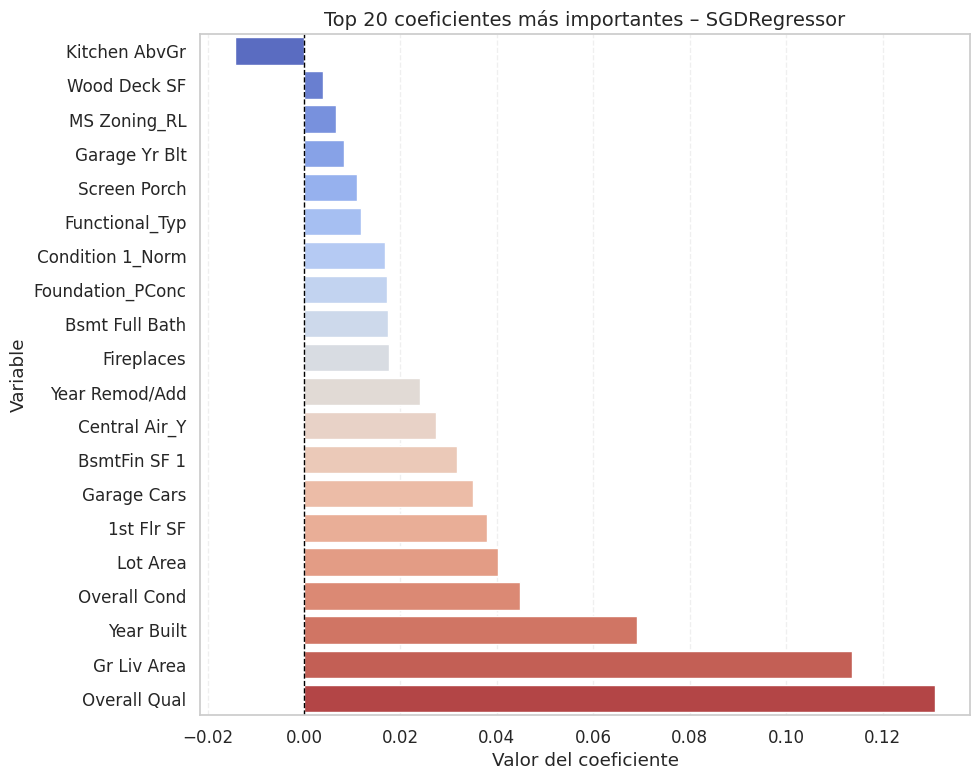

In [46]:
# === Visualización de coeficientes del modelo SGDRegressor ===

# Obtener coeficientes
coef_sgd = modelo_sgd_final.coef_

# Validar tamaño
assert len(coef_sgd) == len(columnas), "Número de coeficientes no coincide con número de variables."

# Crear DataFrame con coeficientes
df_coef_sgd = pd.DataFrame({
    "Variable": columnas,
    "Coeficiente": coef_sgd
})

# Calcular importancia absoluta y filtrar Top 20
df_coef_sgd["Importancia"] = df_coef_sgd["Coeficiente"].abs()
top20_coef_sgd = df_coef_sgd.sort_values(by="Importancia", ascending=False).head(20)

# Ordenar para mejor visualización (coeficiente de menor a mayor)
top20_coef_sgd = top20_coef_sgd.sort_values("Coeficiente")

# Gráfico de barras para coeficientes más importantes
plt.figure(figsize=(10, 8))
sns.barplot(data=top20_coef_sgd, x="Coeficiente", y="Variable", palette="coolwarm", dodge=False)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Top 20 coeficientes más importantes – SGDRegressor", fontsize=14)
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variable")
plt.grid(True, linestyle='--', alpha=0.3, axis='x')
plt.tight_layout()

# Guardar figura
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/top20_coeficientes_sgd.png", dpi=300)
plt.show()


### Análisis de Coeficientes – Top 20 Variables Más Importantes (SGDRegressor)

- **Justificación:**  
  Los coeficientes del modelo lineal SGDRegressor indican la influencia de cada variable en la predicción del precio de la vivienda. Evaluar los coeficientes permite identificar cuáles características aportan positivamente o negativamente al valor estimado.

- **Interpretación:**  
  El gráfico muestra las 20 variables con mayor magnitud de coeficiente absoluto. Variables como *Overall Qual*, *Gr Liv Area* y *Year Built* tienen coeficientes positivos altos, sugiriendo que mejoras en estas características aumentan significativamente el precio. Por otro lado, *Kitchen AbvGr* tiene coeficiente negativo, indicando que puede estar asociada a una disminución en el valor predicho.

- **Inferencia:**  
  Este análisis confirma la relevancia de atributos estructurales y de calidad general en la predicción del precio. La magnitud y signo de los coeficientes proporcionan insights interpretables para entender qué factores influyen más en el modelo. Esto ayuda a validar la lógica del modelo y a comunicar resultados a stakeholders de manera transparente.

Este análisis es clave para interpretar el modelo y tomar decisiones fundamentadas basadas en las variables predictoras más relevantes.


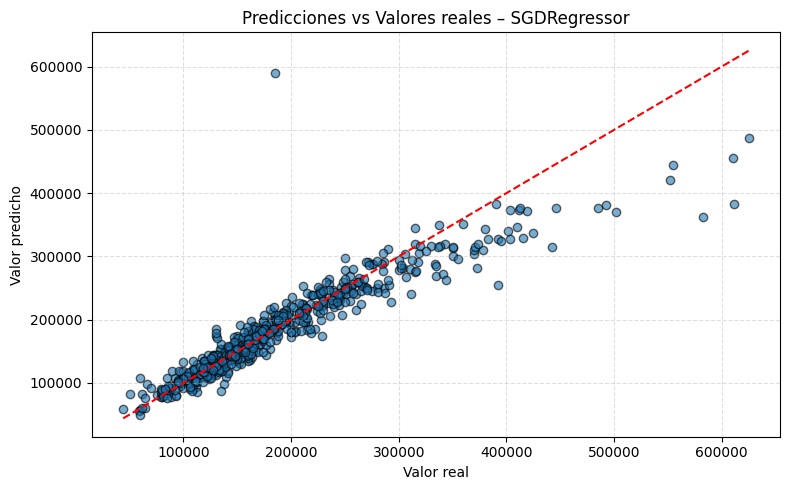

In [24]:
# === Gráfico de Predicciones vs Valores Reales ===
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_test_sgd, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Predicciones vs Valores reales – SGDRegressor")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("figuras/predicho_vs_real_sgd.png", dpi=300)
plt.show()



### Predicciones vs Valores Reales – SGDRegressor

- **Justificación:**  
  Este gráfico compara los valores predichos por el modelo con los valores reales del conjunto de prueba. Es fundamental para evaluar visualmente la precisión y la dispersión de las predicciones.

- **Interpretación:**  
  Los puntos se agrupan en torno a la línea roja discontinua que representa la igualdad perfecta entre valores predichos y reales. Esto indica que el modelo predice bien en general. Sin embargo, algunos puntos se alejan de la diagonal, lo que muestra errores de predicción en casos específicos, probablemente debido a valores atípicos o características no capturadas.

- **Inferencias:**  
  La proximidad mayoritaria de los puntos a la línea diagonal sugiere un buen ajuste global del modelo. La dispersión observada en valores más altos podría indicar heterocedasticidad o que el modelo es menos preciso para viviendas de alto valor. Esta visualización complementa las métricas numéricas para ofrecer una evaluación integral del desempeño del modelo.

Este tipo de gráfico es esencial para validar la calidad predictiva y detectar patrones o desviaciones que merezcan análisis adicional.


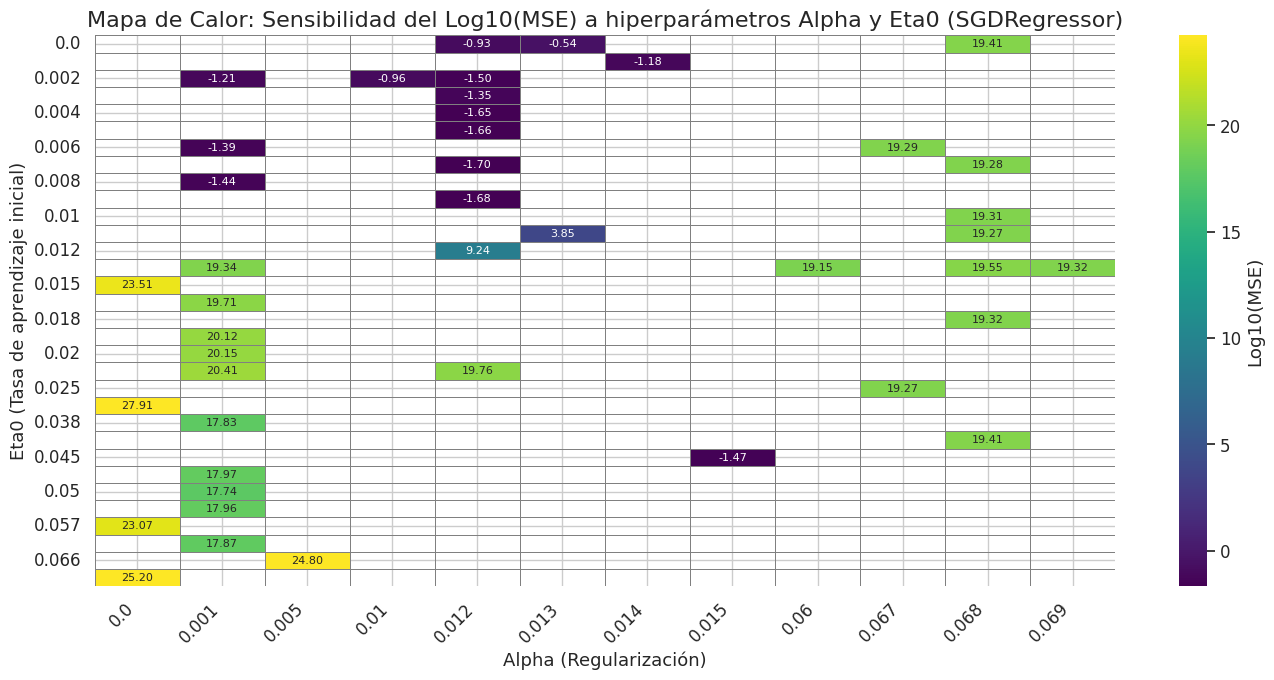

In [44]:
# Copiar para evitar modificar original
df_heatmap = df_bayes_sgd.copy()

# Crear columna MSE absoluta y luego Log10 para manejo de escala
df_heatmap['MSE_abs'] = df_heatmap['mean_test_MSE'].abs()
df_heatmap['log_MSE'] = np.log10(df_heatmap['MSE_abs'] + 1e-20)  # añadir epsilon para evitar log(0)

# Limitar rango con percentiles para evitar valores extremos
vmin = np.percentile(df_heatmap['log_MSE'], 5)
vmax = np.percentile(df_heatmap['log_MSE'], 95)

# Redondeo menos estricto para agrupar más valores
df_heatmap['alpha_round'] = df_heatmap['param_alpha'].round(3)
df_heatmap['eta0_round'] = df_heatmap['param_eta0'].round(3)

# Crear tabla pivote para heatmap
pivot_sgd = df_heatmap.pivot_table(
    index='eta0_round',
    columns='alpha_round',
    values='log_MSE'
)

# Crear máscara para celdas vacías
mask = pivot_sgd.isna()

plt.figure(figsize=(14, 7))
sns.heatmap(
    pivot_sgd,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.4,
    linecolor='gray',
    cbar_kws={"label": "Log10(MSE)"},
    vmin=vmin,
    vmax=vmax,
    mask=mask,
    annot_kws={"size": 8}
)

plt.title("Mapa de Calor: Sensibilidad del Log10(MSE) a hiperparámetros Alpha y Eta0 (SGDRegressor)", fontsize=16)
plt.xlabel("Alpha (Regularización)", fontsize=13)
plt.ylabel("Eta0 (Tasa de aprendizaje inicial)", fontsize=13)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Mapa de Calor: Sensibilidad del Log10(MSE) a hiperparámetros Alpha y Eta0 – SGDRegressor

- **Justificación:**  
  Este mapa de calor visualiza cómo varía la métrica Log10(MSE) en función de dos hiperparámetros críticos: *Alpha* (regularización) y *Eta0* (tasa de aprendizaje inicial). Esta representación facilita la identificación de combinaciones óptimas y sensibles para mejorar el rendimiento del modelo.

- **Interpretación:**  
  Los colores más oscuros indican menores valores de Log10(MSE), lo que corresponde a un mejor ajuste. Por el contrario, los colores más claros y valores positivos reflejan combinaciones con alto error. Se observa que ciertas combinaciones de *Alpha* y *Eta0* proporcionan un desempeño notablemente mejor, lo que es clave para la optimización.

- **Inferencias:**  
  La sensibilidad del modelo a estos hiperparámetros sugiere que una búsqueda cuidadosa es esencial para evitar sobreajuste o subajuste. Valores muy altos o muy bajos de *Alpha* o *Eta0* pueden degradar el rendimiento, mientras que rangos intermedios muestran resultados más estables y precisos. Este análisis respalda la necesidad de técnicas de optimización bayesiana para seleccionar parámetros óptimos.


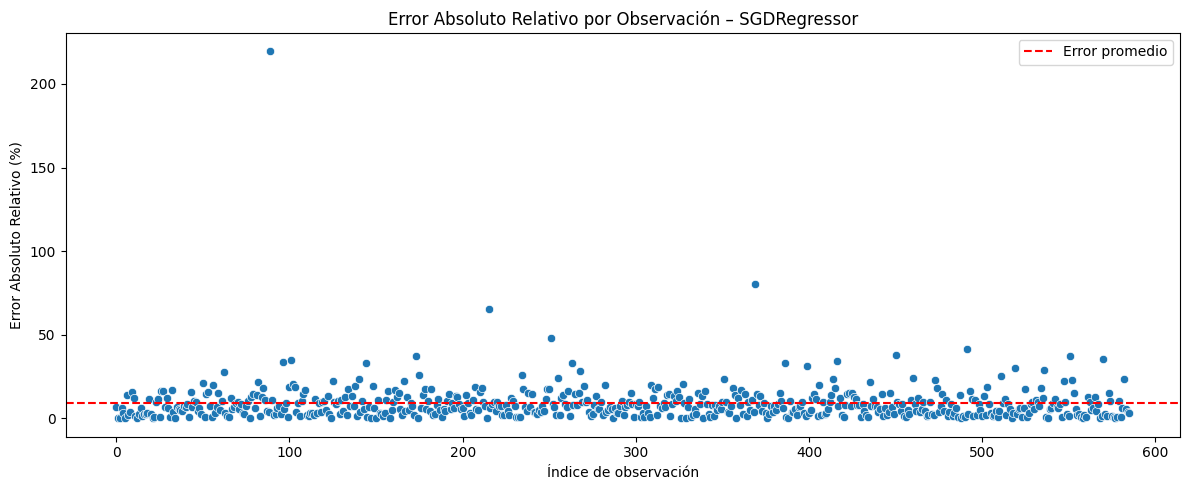

In [26]:
# === 19. Gráfico de Error Absoluto Relativo por Observación ===
df_pred_sgd["Error Absoluto Relativo (%)"] = 100 * np.abs(df_pred_sgd["Actual"] - df_pred_sgd["Predicho"]) / df_pred_sgd["Actual"]

plt.figure(figsize=(12, 5))
sns.scatterplot(x=np.arange(len(df_pred_sgd)), y="Error Absoluto Relativo (%)", data=df_pred_sgd)
plt.axhline(y=df_pred_sgd["Error Absoluto Relativo (%)"].mean(), color='red', linestyle='--', label='Error promedio')
plt.xlabel("Índice de observación")
plt.ylabel("Error Absoluto Relativo (%)")
plt.title("Error Absoluto Relativo por Observación – SGDRegressor")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/error_relativo_por_observacion_sgd.png", dpi=300)
plt.show()


### Error Absoluto Relativo por Observación – SGDRegressor

- **Justificación:**  
  Este gráfico muestra el error absoluto relativo de cada predicción individual, expresado en porcentaje, permitiendo evaluar la precisión del modelo a nivel de observaciones específicas. La inclusión de la línea de error promedio proporciona un punto de referencia para comparar las desviaciones.

- **Interpretación:**  
  Se observa que la mayoría de las observaciones presentan un error relativo bajo, cercano al promedio, indicando un buen desempeño general del modelo. Sin embargo, hay algunas observaciones aisladas con errores significativamente más altos, lo que puede señalar casos atípicos o características no modeladas correctamente.

- **Inferencias:**  
  La dispersión de errores indica que, aunque el modelo es robusto para la mayoría de los datos, existen puntos que podrían beneficiarse de un análisis más detallado o de modelos adicionales para mejorar la predicción. Este tipo de gráfico es útil para identificar datos problemáticos y evaluar la estabilidad del modelo.

---

## Cierre

En este notebook se realizó un análisis exhaustivo del modelo **SGDRegressor** para la predicción de precios en el conjunto de datos Ames Housing. A lo largo del proceso, se optimizaron hiperparámetros mediante búsqueda bayesiana, se evaluó el desempeño mediante métricas robustas, y se realizaron análisis gráficos detallados de residuos y errores.

Los resultados muestran que el modelo tiene un buen balance entre precisión y generalización, aunque con margen para mejoras en casos particulares. Este trabajo sienta los pilares para futuras exploraciones con otros modelos o técnicas de ensamblaje, siempre guiados por análisis rigurosos y visualizaciones claras.

